<a href="https://colab.research.google.com/github/wanyuL/ReinforcementRats2021/blob/master/RNN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run rnn0 on fake data

In [1]:
# Colab:
! git clone https://github.com/wanyuL/ReinforcementRats2021.git 
import sys 
sys.path.append('./ReinforcementRats2021')

Cloning into 'ReinforcementRats2021'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 47 (delta 17), reused 38 (delta 10), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [2]:
import nmastandard
from rnn0 import *
from gen_fake_data import *

In [3]:
device=nmastandard.set_device()  # select device

In [4]:
# prepare for training
NT=250;
ntrials=100
NN=400;
ncomp=10;
fake_spk, fake_spk_rates, latents=gen_fake_spk(NT,ntrials,NN,ncomp)
# we separate the neuron data into two populations: the input and output
x0 = torch.from_numpy(fake_spk_rates[:, :, :200]).to(device).float()   
x1 = torch.from_numpy(fake_spk_rates[:, :, 200:]).to(device).float()

NN1 = x0.shape[-1]
NN2 = x1.shape[-1]

# we initialize the neural network
net = rnn0(ncomp, NN1, NN2, dropout=0.5 ,bidi = False).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x0.mean((0,1))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


iteration 0, train_loss 0.4296 , val_loss 0.4315
iteration 50, train_loss 0.2454 , val_loss 0.3720
iteration 100, train_loss 0.2318 , val_loss 0.4041
iteration 150, train_loss 0.2280 , val_loss 0.4067


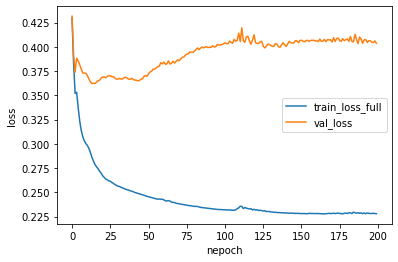

In [5]:
# train the rnn!
_,_,latv = rnn0.train(net,x0,x0,200,0.05,device,30,nn.MSELoss(),x1,x1)
# might not expect the model to generalize well, as the adjacency matrices might 
# differ between different neuron subpopulations

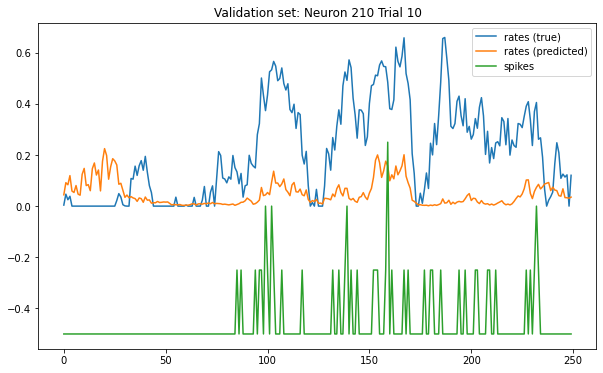

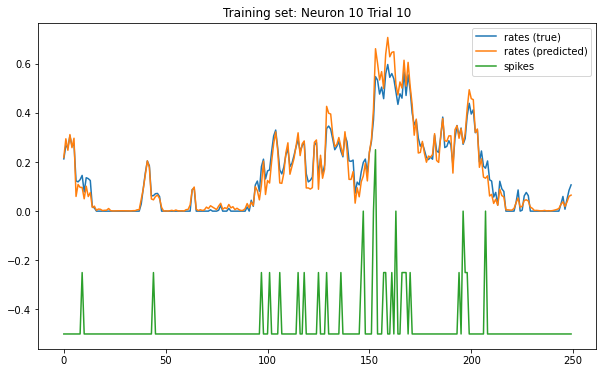

In [21]:
# visualize the performance of the rnn model
netinput=x1
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn = 10
ntrial = 10
plt.figure(figsize=(10, 6))
plt.plot(fake_spk_rates[:,ntrial, nn+200])
plt.plot(rpred[:,ntrial, nn])
plt.plot(-.5 + fake_spk[:, ntrial, nn+200]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Validation set: Neuron {nn+200} Trial {ntrial}')
plt.show()

# training dataset
netinput=x0
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn = 10
ntrial = 10
plt.figure(figsize=(10, 6))
plt.plot(fake_spk_rates[:,ntrial, nn])
plt.plot(rpred[:,ntrial, nn])
plt.plot(-.5 + fake_spk[:, ntrial, nn]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Training set: Neuron {nn} Trial {ntrial}')
plt.show()

In [ ]:
## next: try the model with the real data